In [ ]:
# CORE LIBRARIES
import os
import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  ns

# NLP LIBRARIES
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## KERAS / TENSORFLOW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout , Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# UTILITIES
import joblib

# CONFIGURATION
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings("ignore")


In [12]:
# Basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99677 entries, 0 to 99676
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      99677 non-null  object
 1   label     99677 non-null  object
 2   language  99677 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
None


In [13]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
text        0
label       0
language    0
dtype: int64


In [14]:
# Duplicate check
duplicates = df.duplicated(subset='text').sum()
print("Duplicate rows:", duplicates)

Duplicate rows: 8422


In [15]:
# Remove duplicates 
df.drop_duplicates(subset='text', inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
# label distribution
print("\nLabel distribution:\n", df['label'].value_counts())


Label distribution:
 label
Not Approved    67895
Approved        23360
Name: count, dtype: int64


In [17]:
# language distribution
print("\nLanguage distribution:\n", df['language'].value_counts())


Language distribution:
 language
EN    45991
BN    45224
RN       40
Name: count, dtype: int64


In [18]:
# Empty text check
empty_rows = df[df['text'].str.strip() == ""]
print("\nEmpty text rows:", len(empty_rows))


Empty text rows: 0


In [19]:
# check dataset shape
df.shape

(91255, 3)

In [20]:
# TEXT PREPROCESSING 


# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Stopwords

# English stopwords
stop_en = set(stopwords.words('english'))

# Bangla stopwords
try:
    stop_bn = set(stopwords.words('bengali'))
except:
    stop_bn = set()


# Romanized Bangla stopwords (dataset-specific)
stop_rn = {
    'ami', 'amra', 'tumi', 'tomra', 'se', 'tara', 'amar', 'tomar', 'tar', 'tader',
    'eta', 'ota', 'ekta', 'onek', 'sob', 'kisu', 'kichu', 'ke', 'kar', 'kare',
    'jodi', 'jodiw', 'karon', 'tai', 'ekhono', 'age', 'por', 'ekhon',
    'ar', 'kintu', 'ba', 'ta' , 'tobe', 'tore', 'nay', 'na', 'noy', 'ache', 'chilo', 'thake',
    'jonno', 'sate', 'diyese', 'bolse', 'bole', 'korse', 'korche', 'korse', 'korte',
} 


# Text Cleaning Function
def clean_text(text):
    """Clean text: remove URLs, hashtags, punctuation, normalize spaces."""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)    # remove URLs
    text = re.sub(r'@\w+|#\w+', ' ', text)                # remove mentions, hashtags
    text = re.sub(r'[^\u0980-\u09FFA-Za-z\s]', ' ', text) # keep Bangla + English
    text = re.sub(r'\s+', ' ', text).strip()              # normalize spaces
    return text


# Preprocessing Function

stemmer = PorterStemmer()

def preprocess_text(text, lang=None):
    """Tokenize, remove stopwords for English/Bangla/Romanized, stem English."""
    text = clean_text(text)
    tokens = word_tokenize(text)
    lang = (lang or '').upper()

    if lang == 'BN':  # Bangla
        tokens = [t for t in tokens if t not in stop_bn and len(t) > 1]

    elif lang == 'EN':  # English
        tokens = [stemmer.stem(t) for t in tokens if t not in stop_en and len(t) > 2]

    elif lang == 'RN':  # Romanized Bangla
        tokens = [t for t in tokens if t not in stop_rn and len(t) > 1]

    else:  # fallback for unknown language
        tokens = [t for t in tokens if len(t) > 1]

    return ' '.join(tokens)


# Apply Preprocessing
df['clean_text'] = df.apply(lambda r: preprocess_text(r['text'], r['language']), axis=1)

# Drop empty cleaned texts
df = df[df['clean_text'].str.strip() != ''].reset_index(drop=True)

print(" Text preprocessing complete.")
print("Sample cleaned texts:\n")

df.head(10)

 Text preprocessing complete.
Sample cleaned texts:



,text,label,language,clean_text
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Not Approved,BN,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,Not Approved,BN,জন্ম প্রক্রিয়ার সময় মায়ের ভিতর বাবা হুমায়ুন কব...
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,Not Approved,BN,ধজভংগ দের ভায়াগ্রা লাগবো ধংস কুলখানকিরা
3,বোকাচোদা একটা।,Not Approved,BN,বোকাচোদা একটা
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,Not Approved,BN,তোর দেশে ফেরার অপেক্ষায় রইলাম জেলে একটা কামরা ...
5,বাংলাদেশ ফেসবুক ইজ বিনোদন,Not Approved,BN,বাংলাদেশ ফেসবুক ইজ বিনোদন
6,ক্ষমা করার মালিক উপরওয়ালা। উনি ক্ষমা করে দিলে ...,Not Approved,BN,ক্ষমা মালিক উপরওয়ালা ক্ষমা দিলে মানুষের কিইবা ...
7,আপনি ক্ষমা চেয়েছেন। এটাই বড় কথা।ক্ষমা করার মাল...,Not Approved,BN,ক্ষমা চেয়েছেন বড় কথা ক্ষমা মালিক আল্লাহ একজন ম...
8,নিজের রিভিউ বারানোর জন্যই জতো সব নাটক? ফালতু.....,Not Approved,BN,রিভিউ বারানোর জন্যই জতো নাটক ফালতু
9,আপনাদের সকলের কাছে একটা বিষয়ে অনুরোধ-দয়াকরে এই...,Not Approved,BN,আপনাদের সকলের একটা বিষয়ে অনুরোধ দয়াকরে মহিলা ও...


In [21]:
# Save DataFrame to CSV
df.to_csv('langu_march.csv', index=False)

In [22]:
# Encode labels (Approved=0, Not Approved=1)
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Show mapping
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Sanity check: balanced labels
print("\nLabel counts:\n", df['encoded_label'].value_counts())

Label mapping: {'Approved': np.int64(0), 'Not Approved': np.int64(1)}

Label counts:
 encoded_label
1    67565
0    23061
Name: count, dtype: int64


In [23]:
# Train-Test Split

X = df['clean_text']
y = df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

Training samples: 72500 | Testing samples: 18126


In [24]:
# Tokenizer + Padding + Embedding Preparation

# Tokenizer setup
MAX_VOCAB = 30000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenizer and padding completed successfully.")
print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape:  {X_test_pad.shape}")


Tokenizer and padding completed successfully.
Training data shape: (72500, 100)
Testing data shape:  (18126, 100)


Epoch 1/10


2025-12-22 12:27:14.300131: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


454/454 ━━━━━━━━━━━━━━━━━━━━ 57s 121ms/step - accuracy: 0.7433 - loss: 0.5770 - val_accuracy: 0.7443 - val_loss: 0.5693
Epoch 2/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.7458 - loss: 0.5718 - val_accuracy: 0.7443 - val_loss: 0.5685
Epoch 3/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.7458 - loss: 0.5710 - val_accuracy: 0.7443 - val_loss: 0.5708
Epoch 4/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.7458 - loss: 0.5701 - val_accuracy: 0.7443 - val_loss: 0.5685
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step

Simple RNN Test Accuracy: 0.7456

Classification Report (Simple RNN):

              precision    recall  f1-score   support

    Approved       0.00      0.00      0.00      4612
Not Approved       0.75      1.00      0.85     13514

    accuracy                           0.75     18126
   macro avg       0.37      0.50      0.43     18126
weighted avg      

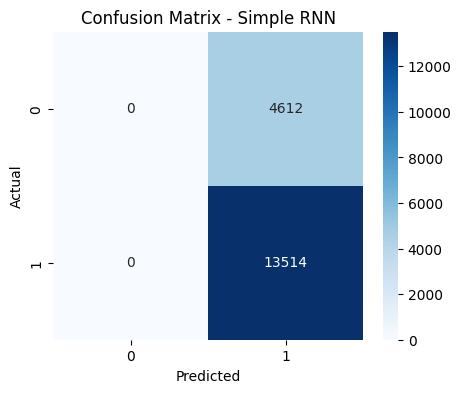

In [25]:
# Simple RNN Model

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',          # observe validation loss 
    patience=2,                  
    restore_best_weights=True,   # restore best model weight 
    verbose=1
)

# Model architecture
rnn_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    SimpleRNN(128, dropout=0.3, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Test Accuracy
test_acc_rnn = accuracy_score(y_test, y_pred_rnn)
print(f"\nSimple RNN Test Accuracy: {test_acc_rnn:.4f}\n")

# Classification Report
print("Classification Report (Simple RNN):\n")
print(classification_report(y_test, y_pred_rnn, target_names=['Approved', 'Not Approved']))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rnn), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Simple RNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# BiLSTM Model

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',          # observe validation loss 
    patience=2,                  
    restore_best_weights=True,   # restore best model weight 
    verbose=1
)

# Model architecture
bilstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


# Evaluation
y_pred_bilstm = (bilstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Test Accuracy
test_acc_bilstm = accuracy_score(y_test, y_pred_bilstm)
print(f"\nBiLSTM Test Accuracy: {test_acc_bilstm:.4f}\n")

# Classification Report
print("Classification Report (BiLSTM):\n")
print(classification_report(y_test, y_pred_bilstm, target_names=['Approved', 'Not Approved']))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Epoch 1/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 205s 439ms/step - accuracy: 0.8428 - loss: 0.3325 - val_accuracy: 0.8702 - val_loss: 0.2740
Epoch 2/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 196s 431ms/step - accuracy: 0.9052 - loss: 0.2170 - val_accuracy: 0.8749 - val_loss: 0.2834
Epoch 3/10
394/454 ━━━━━━━━━━━━━━━━━━━━ 56s 941ms/step - accuracy: 0.9339 - loss: 0.1600

In [ ]:
# LSTM Model


# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',          # observe validation loss
    patience=2,
    restore_best_weights=True,   # restore best model weight
    verbose=1
)

# Model architecture
lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    LSTM(128, dropout=0.3, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


# Evaluation
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Test Accuracy
test_acc_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"\nLSTM Test Accuracy: {test_acc_lstm:.4f}\n")

# Classification Report
print("Classification Report (LSTM):\n")
print(classification_report(y_test, y_pred_lstm, target_names=['Approved', 'Not Approved']))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# 1D CNN Model

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',          # observe validation loss 
    patience=2,                  
    restore_best_weights=True,   # restore best model weight 
    verbose=1
)

# Model architecture
cnn_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred_cnn = (cnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Test Accuracy
test_acc_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"\n1D CNN Test Accuracy: {test_acc_cnn:.4f}\n")

# Classification Report
print("Classification Report (1D CNN):\n")
print(classification_report(y_test, y_pred_cnn, target_names=['Approved', 'Not Approved']))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# DL Model Accuracy Comparison

model_scores_dl = {
    "Simple RNN": round(test_acc_rnn, 4),
    "LSTM": round(test_acc_lstm, 4),
    "BiLSTM": round(test_acc_bilstm, 4),
    "1D CNN": round(test_acc_cnn, 4),
}

# Convert to DataFrame and sort by Accuracy
df_scores_dl = pd.DataFrame(model_scores_dl.items(), columns=['Model', 'Accuracy'])
df_scores_dl = df_scores_dl.sort_values(by='Accuracy', ascending=False)

# Display results
print("\n Deep Learning Model Comparison:\n")
print(df_scores_dl.to_string(index=False))

# Plot
plt.figure(figsize=(7,5))
sns.barplot(data=df_scores_dl, x='Model', y='Accuracy', palette='mako')
plt.title('\nModel Accuracy Comparison (Deep Learning)', fontsize=13, fontweight='bold')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate training, validation, and testing accuracy of all Deep Learning Models using 5-Fold Cross Validation
 
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

def evaluate_dl_model_cv(model, X_train, y_train, X_test, y_test, model_name="Model"):
    print(f"\n{'='*15} {model_name} {'='*15}")

    # Setup
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    acc_train_list, acc_val_list = [], []
    prec_train_list, prec_val_list = [], []
    rec_train_list, rec_val_list = [], []
    f1_train_list, f1_val_list = [], []

    # 5-Fold CV (Training + Validation)
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Recreate a fresh copy of the trained model (to avoid weight carryover)
        temp_model = tf.keras.models.clone_model(model)
        temp_model.set_weights(model.get_weights())
        temp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Evaluate on training fold
        y_tr_pred = (temp_model.predict(X_tr, verbose=0) > 0.5).astype(int)
        y_val_pred = (temp_model.predict(X_val, verbose=0) > 0.5).astype(int)

        # Training metrics
        acc_train_list.append(accuracy_score(y_tr, y_tr_pred))
        prec_train_list.append(precision_score(y_tr, y_tr_pred, zero_division=0))
        rec_train_list.append(recall_score(y_tr, y_tr_pred, zero_division=0))
        f1_train_list.append(f1_score(y_tr, y_tr_pred, zero_division=0))

        # Validation metrics
        acc_val_list.append(accuracy_score(y_val, y_val_pred))
        prec_val_list.append(precision_score(y_val, y_val_pred, zero_division=0))
        rec_val_list.append(recall_score(y_val, y_val_pred, zero_division=0))
        f1_val_list.append(f1_score(y_val, y_val_pred, zero_division=0))

    # Mean ± std for training
    acc_train_mean, acc_train_std = np.mean(acc_train_list), np.std(acc_train_list)
    prec_train_mean, rec_train_mean, f1_train_mean = map(np.mean, [prec_train_list, rec_train_list, f1_train_list])

    # Mean for validation
    acc_val_mean, prec_val_mean, rec_val_mean, f1_val_mean = map(np.mean, [acc_val_list, prec_val_list, rec_val_list, f1_val_list])

    # Test performance using already trained model
    y_pred_test = (model.predict(X_test, verbose=0) > 0.5).astype(int)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test, zero_division=0)
    rec_test = recall_score(y_test, y_pred_test, zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, zero_division=0)

    # Print Results 
    print("\nTraining Performance (5-Fold CV):")
    print(f"Accuracy:  {acc_train_mean:.4f} ± {acc_train_std:.4f}")
    print(f"Precision: {prec_train_mean:.4f}")
    print(f"Recall:    {rec_train_mean:.4f}")
    print(f"F1-score:  {f1_train_mean:.4f}")

    print("\nValidation Performance (5-Fold CV):")
    print(f"Accuracy:  {acc_val_mean:.4f}")
    print(f"Precision: {prec_val_mean:.4f}")
    print(f"Recall:    {rec_val_mean:.4f}")
    print(f"F1-score:  {f1_val_mean:.4f}")

    print("\nTesting Performance:")
    print(f"Accuracy:  {acc_test:.4f}")
    print(f"Precision: {prec_test:.4f}")
    print(f"Recall:    {rec_test:.4f}")
    print(f"F1-score:  {f1_test:.4f}")

    # Generalization Check
    acc_gap = acc_train_mean - acc_test
    f1_gap = f1_train_mean - f1_test

    if acc_gap > 0.05 or f1_gap > 0.05:
        print("\n Potential Overfitting: Training metrics significantly higher than test metrics.")
    elif acc_train_mean < 0.75 and acc_test < 0.75:
        print("\n Potential Underfitting: Both training and test accuracies are low.")
    else:
        print("\n The model seems to generalize well with balanced training and testing performance.")


# Run on all trained DL models
evaluate_dl_model_cv(rnn_model, X_train_pad, y_train.values, X_test_pad, y_test.values, "Simple RNN")
evaluate_dl_model_cv(lstm_model, X_train_pad, y_train.values, X_test_pad, y_test.values, "LSTM")
evaluate_dl_model_cv(bilstm_model, X_train_pad, y_train.values, X_test_pad, y_test.values, "BiLSTM")
evaluate_dl_model_cv(cnn_model, X_train_pad, y_train.values, X_test_pad, y_test.values, "1D CNN")


In [ ]:
# ROC–AUC Visualization - ML Models

from sklearn.metrics import roc_curve, auc

# Probabilities from trained models
y_prob_rnn = rnn_model.predict(X_test_pad)
y_prob_lstm = lstm_model.predict(X_test_pad)
y_prob_bilstm = bilstm_model.predict(X_test_pad)
y_prob_cnn = cnn_model.predict(X_test_pad)

# Compute ROC curve and AUC
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_prob_rnn)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm)
fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test, y_prob_bilstm)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_prob_cnn)

auc_rnn = auc(fpr_rnn, tpr_rnn)
auc_lstm = auc(fpr_lstm, tpr_lstm)
auc_bilstm = auc(fpr_bilstm, tpr_bilstm)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_rnn, tpr_rnn, label=f"Simple RNN (AUC = {auc_rnn:.3f})")
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {auc_lstm:.3f})")
plt.plot(fpr_bilstm, tpr_bilstm, label=f"BiLSTM (AUC = {auc_bilstm:.3f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"1D CNN (AUC = {auc_cnn:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")

plt.title("ROC Curves – Deep Learning Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



BiLSTM and 1D CNN show the strongest performance (AUC ≈ 0.935), clearly separating classes.  
Simple RNN performs near random (AUC ≈ 0.52), while LSTM underperforms (AUC ≈ 0.50).  
Overall, **BiLSTM and 1D CNN** are the best deep models for this task.
